<a href="https://colab.research.google.com/github/JS555555/ANN-implementation/blob/implementing-ANN-using-tensorflow/ANN_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from sklearn import datasets
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### Data preprocessing

In [4]:
X, y = datasets.make_classification(n_samples=10000, n_features=5, n_informative=3, n_classes=4)

# Standardization
X_standarized = (X - X.mean())/X.std()


# Spliting data into test and train
N = X.shape[0]

X_train, y_train = X_standarized[:int(N*0.8)], y[:int(N*0.8)]
X_test, y_test = X_standarized[int(N*0.8):], y[int(N*0.8):]

# One-hot encoding targets
y_train_onehot = np.zeros((y_train.size, y_train.max() + 1))
y_train_onehot[np.arange(y_train.size), y_train] = 1
y_test_onehot = np.zeros((y_test.size, y_test.max() + 1))
y_test_onehot[np.arange(y_test.size), y_test] = 1

###Implementing ANN using numpy

In [5]:
def forward(X, W1, b1, W2, b2):
    Z = X.dot(W1) + b1
    Z[Z < 0] = 0

    A = Z.dot(W2) + b2
    expA = np.exp(A)
    pY = expA / expA.sum(axis=1, keepdims=True)
    return pY, Z

In [6]:
def derivative_w2(Z, Y, pY):
    return Z.T.dot(pY - Y)

def derivative_b2(Y, pY):
    return (pY - Y).sum(axis=0)

def derivative_w1(X, Z, Y, pY, W2):
    return X.T.dot( ( ( pY-Y ).dot(W2.T) * (Z > 0) ) )

def derivative_b1(Z, Y, pY, W2):
    return (( pY-Y ).dot(W2.T) * (Z > 0)).sum(axis=0)

In [7]:
def classification_rate(Y, pY):
    return np.mean(Y == pY)

def cross_entropy(Y, pY):
    return -np.mean(Y * np.log(pY+10e-7))

In [8]:
iterations = 500
append_iterations = 50

learning_rate = 10e-8

N, D = X_train.shape
K = len(set(y))
M = 500 # number of hidden units

batch_size = 500
n_batches = N // batch_size

W1 = np.random.randn(D, M) / np.sqrt(D)
b1 = np.zeros(M)
W2 = np.random.randn(M, K) / np.sqrt(M)
b2 = np.zeros(K)

cost_train = []
cost_test = []

classification_rate_train = []
classification_rate_test = []


mu = 0.9
dW2 = 0
db2 = 0
dW1 = 0
db1 = 0

# SGD
for i in range(iterations):
    for j in range(n_batches):
        Xbatch = X_train[j*batch_size:(j*batch_size + batch_size),]
        Ybatch = y_train_onehot[j*batch_size:(j*batch_size + batch_size),]
        pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)

        # gradients
        gW2 = derivative_w2(Z, Ybatch, pYbatch)
        gb2 = derivative_b2(Ybatch, pYbatch)
        gW1 = derivative_w1(Xbatch, Z, Ybatch, pYbatch, W2)
        gb1 = derivative_b1(Z, Ybatch, pYbatch, W2)

        # update velocities
        dW2 = mu*dW2 - learning_rate*gW2
        db2 = mu*db2 - learning_rate*gb2
        dW1 = mu*dW1 - learning_rate*gW1
        db1 = mu*db1 - learning_rate*gb1

        # updates
        W2 += dW2
        b2 += db2
        W1 += dW1
        b1 += db1

        if j % append_iterations == 0:
            # train set
            pY, _ = forward(X_train, W1, b1, W2, b2)
            l = cross_entropy(pY, y_train_onehot)
            cost_train.append(l)

            e = classification_rate(np.argmax(pY, axis=1), y_train)
            classification_rate_train.append(e)

            # test set
            pY_test, _ = forward(X_test, W1, b1, W2, b2)
            l_test = cross_entropy(pY_test, y_test_onehot)
            cost_test.append(l_test)

            e_test = classification_rate(np.argmax(pY_test, axis=1), y_test)
            classification_rate_test.append(e_test)

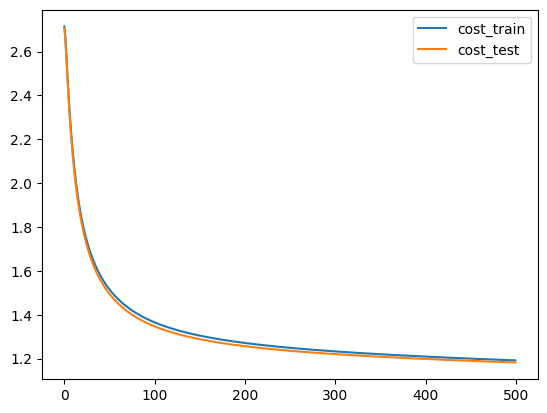

In [9]:
plt.plot(cost_train, label="cost_train")
plt.plot(cost_test, label="cost_test")
plt.legend();

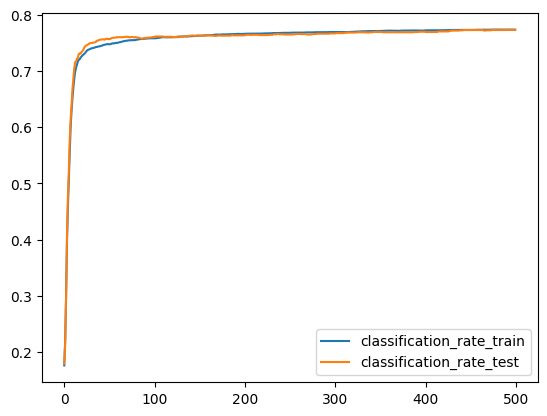

In [10]:
plt.plot(classification_rate_train, label="classification_rate_train")
plt.plot(classification_rate_test, label="classification_rate_test")
plt.legend();

###Implementing ANN using TensorFlow


In [ ]:
learning_rate = 10e-4
momentum = 0.9
sgd_optimizer = tf.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(K, activation='softmax')])

model.compile(optimizer=sgd_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 500
epochs = 500
validation_data = (X_test, y_test_onehot)
r = model.fit(X_train, y_train_onehot, validation_data=validation_data, batch_size=batch_size, epochs=epochs)

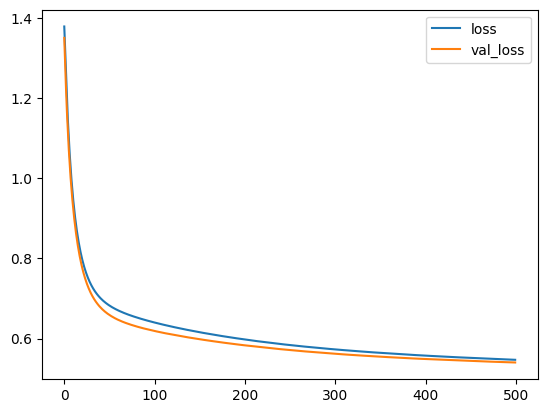

In [44]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

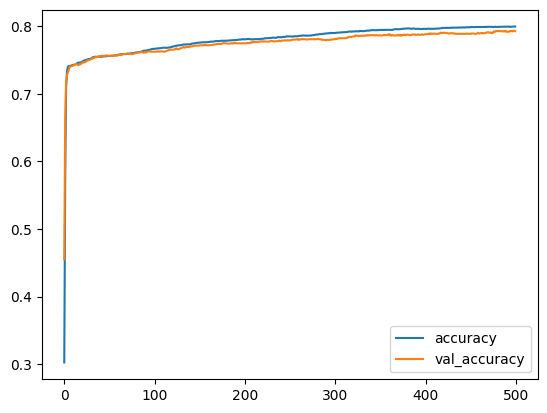

In [45]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend();

######Will the Adam optimizer perform better?

In [48]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(K, activation='softmax')])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 500
epochs = 500
validation_data = (X_test, y_test_onehot)
r_adam = model.fit(X_train, y_train_onehot, validation_data=validation_data, batch_size=batch_size, epochs=epochs)

Epoch 1/500
16/16 [==============================] - 1s 26ms/step - loss: 1.1574 - accuracy: 0.6519 - val_loss: 0.9450 - val_accuracy: 0.7375
Epoch 2/500
16/16 [==============================] - 0s 15ms/step - loss: 0.8525 - accuracy: 0.7436 - val_loss: 0.7433 - val_accuracy: 0.7485
Epoch 3/500
16/16 [==============================] - 0s 11ms/step - loss: 0.7225 - accuracy: 0.7545 - val_loss: 0.6643 - val_accuracy: 0.7580
Epoch 4/500
16/16 [==============================] - 0s 12ms/step - loss: 0.6731 - accuracy: 0.7598 - val_loss: 0.6335 - val_accuracy: 0.7615
Epoch 5/500
16/16 [==============================] - 0s 9ms/step - loss: 0.6483 - accuracy: 0.7655 - val_loss: 0.6164 - val_accuracy: 0.7645
Epoch 6/500
16/16 [==============================] - 0s 8ms/step - loss: 0.6307 - accuracy: 0.7720 - val_loss: 0.6035 - val_accuracy: 0.7705
Epoch 7/500
16/16 [==============================] - 0s 8ms/step - loss: 0.6164 - accuracy: 0.7761 - val_loss: 0.5915 - val_accuracy: 0.7730
Epoch 8/5

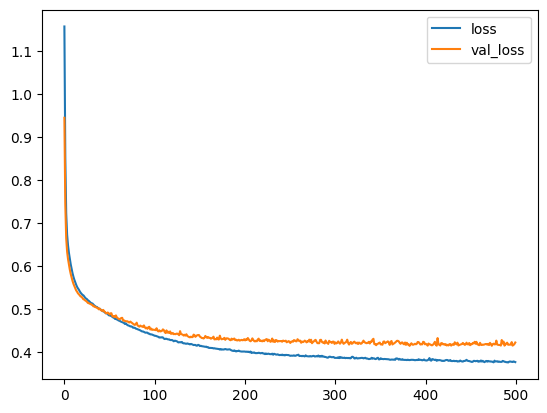

In [49]:
plt.plot(r_adam.history['loss'], label='loss')
plt.plot(r_adam.history['val_loss'], label='val_loss')
plt.legend();

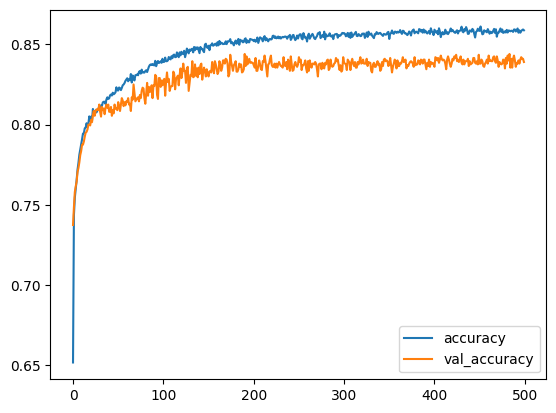

In [50]:
plt.plot(r_adam.history['accuracy'], label='accuracy')
plt.plot(r_adam.history['val_accuracy'], label='val_accuracy')
plt.legend();

#####Is more hidden layers better than more hidden units?

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(K, activation='softmax')])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 500
epochs = 500
validation_data = (X_test, y_test_onehot)
r_adam_l = model.fit(X_train, y_train_onehot, validation_data=validation_data, batch_size=batch_size, epochs=epochs)

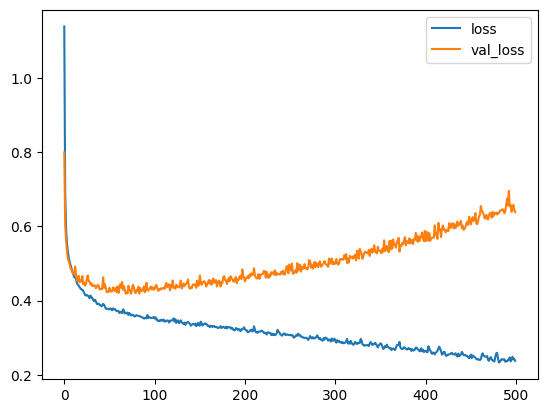

In [52]:
plt.plot(r_adam_l.history['loss'], label='loss')
plt.plot(r_adam_l.history['val_loss'], label='val_loss')
plt.legend();

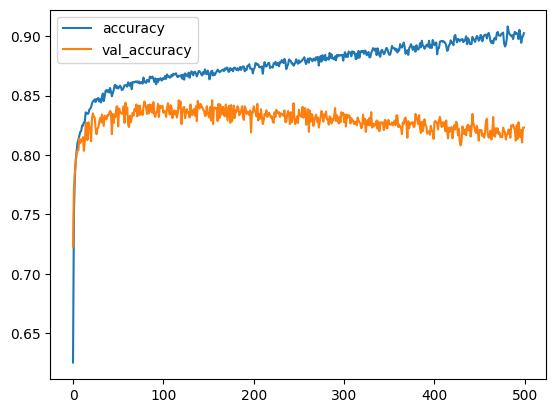

In [53]:
plt.plot(r_adam_l.history['accuracy'], label='accuracy')
plt.plot(r_adam_l.history['val_accuracy'], label='val_accuracy')
plt.legend();

#####Model tends to overfit. Will dropout regularization help?

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(K, activation='softmax')])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 500
epochs = 500
validation_data = (X_test, y_test_onehot)
r_adam_w_dropout = model.fit(X_train, y_train_onehot, validation_data=validation_data, batch_size=batch_size, epochs=epochs)

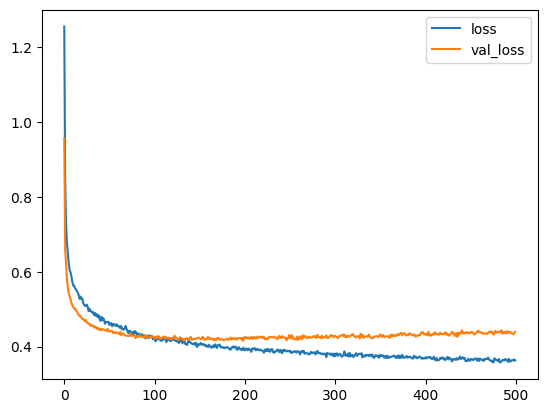

In [55]:
plt.plot(r_adam_w_dropout.history['loss'], label='loss')
plt.plot(r_adam_w_dropout.history['val_loss'], label='val_loss')
plt.legend();

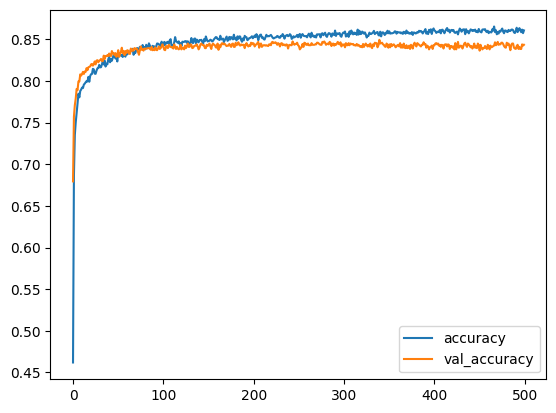

In [56]:
plt.plot(r_adam_w_dropout.history['accuracy'], label='accuracy')
plt.plot(r_adam_w_dropout.history['val_accuracy'], label='val_accuracy')
plt.legend();